In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import ml_metrics as mlm
import pickle

import sklearn as sl
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing, metrics, linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, train_test_split, learning_curve

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [2]:
train = pd.read_csv('train.csv',index_col=False)
#test = pd.read_csv('test.csv',index_col=False)

#### Print first few rows of data

In [3]:
train.head()

,age,exercise,competitive,height,weight,gender,injured,color,sleep,race,jump
0,23,3,2,61.0,106.0,1,2,5,7.0,5,431
1,23,2,2,63.8,123.5,1,2,5,7.0,5,409
2,24,2,2,70.8,190.0,2,2,4,6.0,5,512
3,24,3,2,69.0,143.0,2,2,2,8.0,5,497
4,24,2,1,68.8,147.0,2,2,2,7.0,5,500


#### Print 'jump' statistics

In [4]:
print(train['jump'].describe())

count     26.000000
mean     436.038462
std       68.838641
min      313.000000
25%      391.000000
50%      425.500000
75%      496.500000
max      579.000000
Name: jump, dtype: float64


#### Plot distribution of the 'jump' data

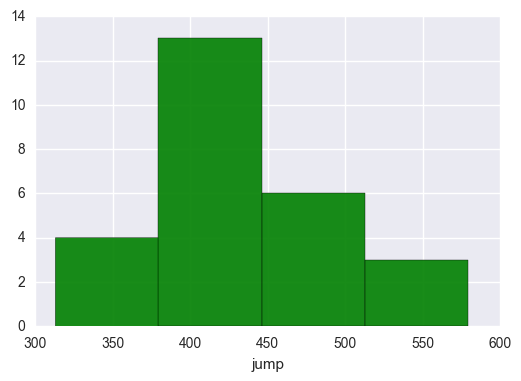

In [5]:
sns.distplot(train['jump'], kde = False, color = 'g', hist_kws={'alpha': 0.9})

#### Corelation of all numerical data in the dataset as a heat map

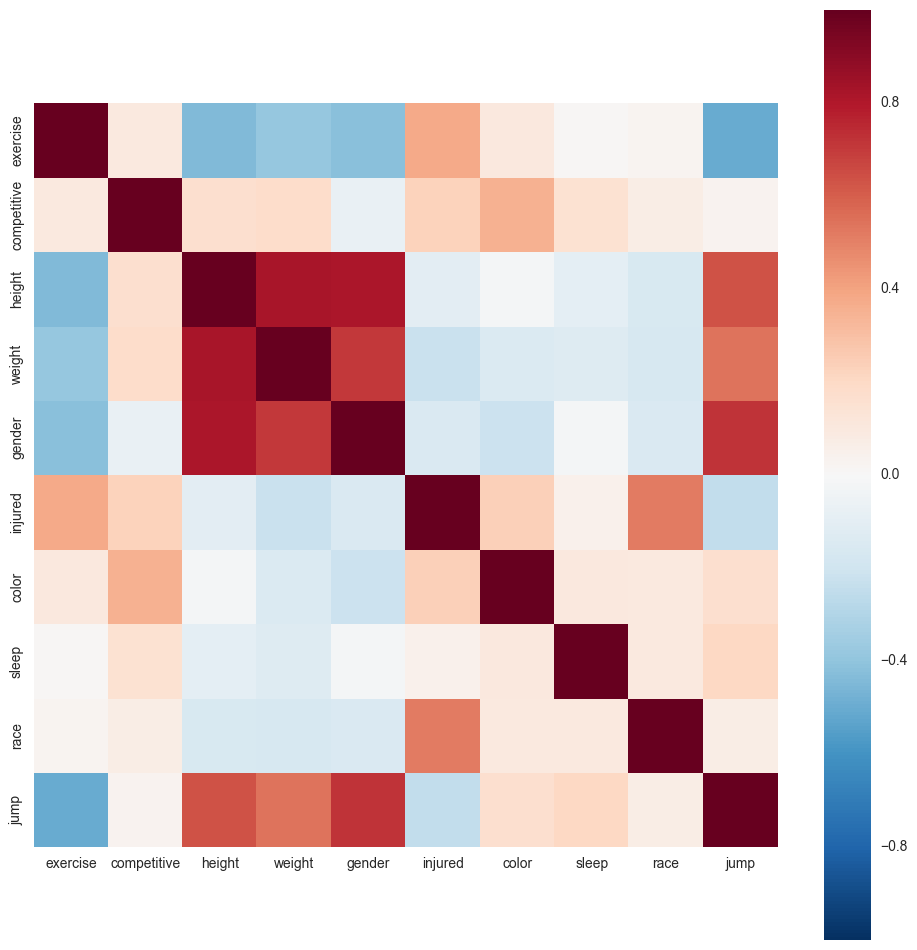

In [6]:
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

#### List the numerical features decendingly by their correlation with the jump:

In [7]:
cor_dict = corr['jump'].to_dict()
del cor_dict['jump']
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

gender: 	0.7195351437438396
height: 	0.6358790173502066
weight: 	0.5468572659443864
exercise: 	-0.5061236600032418
injured: 	-0.2423428033028644
sleep: 	0.20587741907300838
color: 	0.1706992778363859
race: 	0.07455551659423719
competitive: 	0.03736936119996898


#### Categorical data transformed to One Hot Encodeing and extract log of all numerical data

In [8]:
train["jump"] = np.log(train["jump"])

numerical_data = ['age', 'height', 'weight', 'sleep']
train[numerical_data] = np.log1p(train[numerical_data])
train = pd.get_dummies(train, columns=['exercise', 'competitive', 'gender', 'injured', 'color', 'race'])
#train = train.fillna(train.mean())

# numerical_data = all_data.dtypes[all_data.dtypes != "object"].index
# all_data[numerical_data] = np.log1p(all_data[numerical_data])
# all_data = pd.get_dummies(all_data)
# all_data = all_data.fillna(all_data.mean())

#### Plot distribution of the 'jump' data after corrections

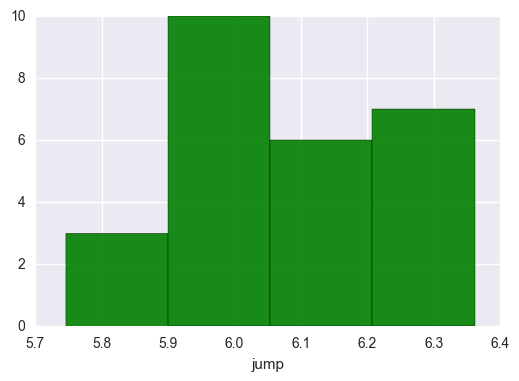

In [9]:
sns.distplot(train['jump'], kde = False, color = 'g', hist_kws={'alpha': 0.9})

# Algorithm comparison

#### Define input and labels

In [10]:
# X_train = all_data[:train.shape[0]]
# X_test = all_data[train.shape[0]:]
# y = train.SalePrice

X_train = train.drop('jump', axis=1)
y = train.jump

#### BoostedGD model

In [11]:
alpha = 0.95
boostedGD = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9, max_features='sqrt')
boostedGD.fit(X_train,y)
y_upper = boostedGD.predict(X_train)
print("Score:" + str(boostedGD.score(X_train,y)))

boostedGD.set_params(alpha=1.0 - alpha)
boostedGD.fit(X_train,y)
y_lower = boostedGD.predict(X_train)
print("Score:" + str(boostedGD.score(X_train,y)))

boostedGD.set_params(loss='ls')
boostedGD.fit(X_train,y)
y_pred = boostedGD.predict(X_train)
print("Score:" + str(boostedGD.score(X_train,y)))

Score:-0.147149600242
Score:-0.705891763814
Score:0.788706418061


#### Lasso Model

In [15]:
lasso = linear_model.LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.0001], max_iter=200, tol=0.01, cv=10).fit(X_train, y)
lasso.predict(X_train), lasso.score(X_train,y)

(array([ 6.03904174,  6.01517825,  6.23295789,  6.19450689,  6.19845326,
         5.94490578,  6.24986647,  6.07522275,  5.98336318,  5.82038374,
         6.24876202,  5.93979942,  6.22509507,  6.05122772,  6.04904198,
         5.85420478,  5.98824778,  6.2376511 ,  6.06984684,  6.20120048,
         6.28751643,  5.79430426,  6.01384263,  6.08479796,  5.96892336,
         5.94243957]), 0.9051049952311625)

#### Print final coefficients used by lasso

In [13]:
pd.Series(lasso.coef_, index = X_train.columns)

age              0.000000e+00
height           0.000000e+00
weight           0.000000e+00
sleep            0.000000e+00
exercise_1       5.118868e-02
exercise_2      -0.000000e+00
exercise_3       2.386350e-02
exercise_4      -1.221537e-02
exercise_5      -9.575218e-03
competitive_1    1.090129e-02
competitive_2   -1.690858e-02
competitive_3    0.000000e+00
gender_1        -2.186286e-01
gender_2         6.137204e-16
injured_1        1.282950e-01
injured_2       -3.111440e-16
color_1         -8.048648e-02
color_2         -5.176685e-02
color_3         -2.058596e-02
color_4          1.054766e-02
color_5          1.139662e-02
color_7          8.101633e-02
race_1          -1.170623e-01
race_4          -1.426865e-01
race_5           4.539075e-03
race_6           7.295559e-02
race_8           2.366695e-02
race_9          -0.000000e+00
dtype: float64

#### How many features were eliminated

In [14]:
coef = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 21 variables and eliminated the other 7 variables


#### Random Forest Regressor

In [15]:
forest = RandomForestRegressor(n_estimators=200, random_state=None,
                               n_jobs=-1, max_depth=100, min_samples_split=10,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2')
forest.fit(X_train, y)
print("score:" + str(forest.score(X_train,y)))

score:0.62833620035


#### Adaboost

In [18]:
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(X_train, y, test_size=0.2)

ada = AdaBoostRegressor(n_estimators=50, learning_rate=0.1, loss='exponential', random_state=None)
ada.fit(train_dataset, train_labels)
ada.predict(valid_dataset), ada.score(valid_dataset,valid_labels)

(array([ 6.20556583,  6.21739976,  6.04926683,  6.05048722,  6.00492012,
         6.05048722]), -0.10241492601234126)

#### Prepare for submition

In [126]:
res = ada.predict(X_train)
np.exp(res)

#submission = pd.DataFrame({'Id': np.array(test["Id"]), 'jump': np.exp(res)})
#submission.to_csv('result.csv',index=False)

array([ 416.01599706,  411.29417171,  504.99682617,  497.        ,
        502.28289426,  401.91992475,  562.42036422,  424.95201242,
        401.91992475,  386.47380248,  509.74357631,  377.77638889,
        499.99099992,  404.        ,  413.09920866,  316.62453265,
        397.12543686,  488.3400069 ,  437.21204429,  497.32909123,
        527.45981602,  324.        ,  407.94193018,  416.46379319,
        396.45221974,  382.        ])

## Comparison Plots

#### Compare Lasso and Random Forest final feature usage

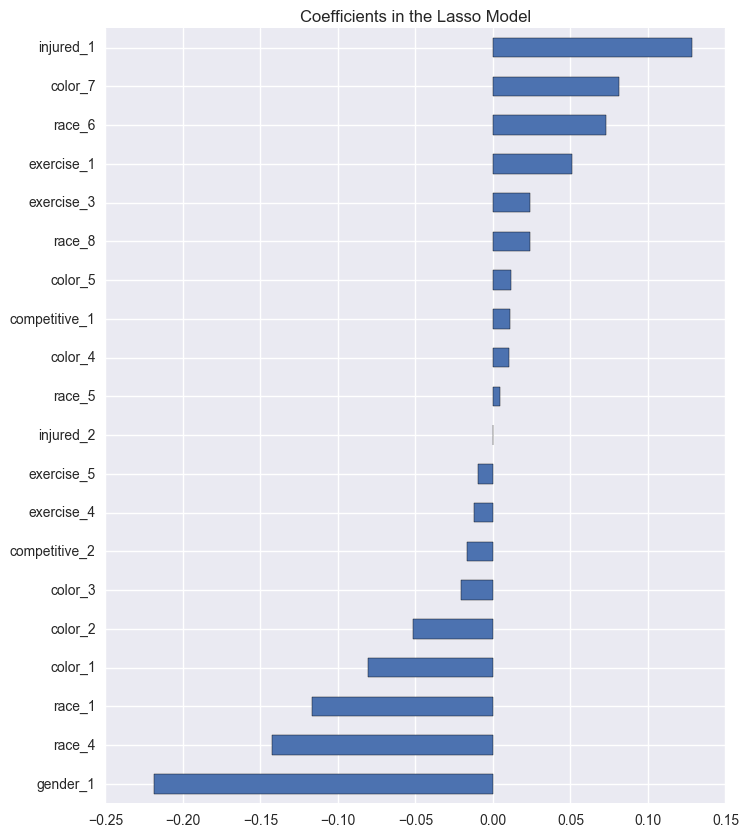

In [127]:
coef = pd.Series(lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

#### Extract features used by estimatr trees and standardize

In [128]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

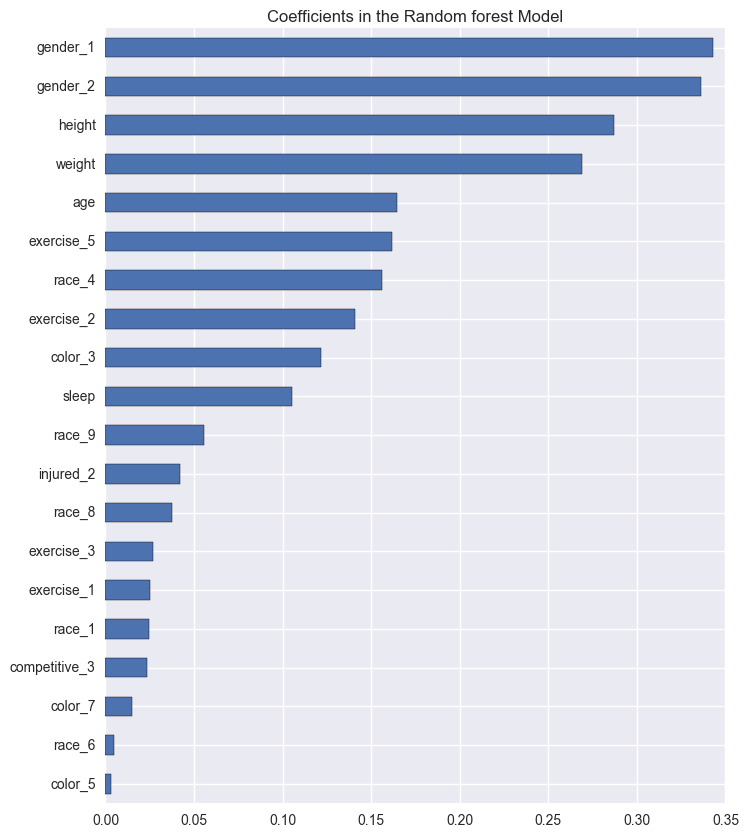

In [129]:
coef = pd.Series(std, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Random forest Model")

# Neural Net Resgression

#### Prepare data for net models

In [135]:
train = pd.read_csv('train.csv',index_col=False)
#test = pd.read_csv('test.csv',index_col=False)

# all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
#                       test.loc[:,'MSSubClass':'SaleCondition']))

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(X_train, y, test_size=0.2)
train_dataset = train_dataset.as_matrix()
valid_dataset = valid_dataset.as_matrix()
#test_dataset = test_dataset.as_matrix()
train_labels = train_labels.values
valid_labels = valid_labels.values

#print('Training set', train_dataset.shape, train_labels.shape)
#print('Validation set', valid_dataset.shape, valid_labels.shape)
#print('Test set', test_dataset.shape)

#### Normalize by reshaping and using standard score method

In [136]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma
def append_bias_reshape(features,labels = None):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim+1])
    if labels is None:
        return f
    labels = (labels-min(labels))/(max(labels)-min(labels))
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

normalized_train_features = feature_normalize(train_dataset)
normalized_valid_features = feature_normalize(valid_dataset)
#normalized_test_features = feature_normalize(test_dataset)


train_dataset, train_labels = append_bias_reshape(normalized_train_features,train_labels)
valid_dataset, valid_labels = append_bias_reshape(normalized_valid_features,valid_labels)
#test_dataset = append_bias_reshape(normalized_test_features,)

train_dataset = np.nan_to_num(train_dataset)
valid_dataset = np.nan_to_num(valid_dataset)
#test_dataset = np.nan_to_num(test_dataset)

/Users/orpaz/Virtual-Environments/ml/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


## Simple Gradient Decent 'one layer nueral net'

#### define simple linear model

In [137]:
learning_rate = 0.001
training_epochs = 1000
cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,train_dataset.shape[1]])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([train_dataset.shape[1],1]))

init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


#### Define train step 

In [138]:
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

#### Run the model and retain cost history

In [139]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_dataset,Y:train_labels})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_dataset,Y: train_labels}))

#### Plotting the squared mean of the distance to the true values

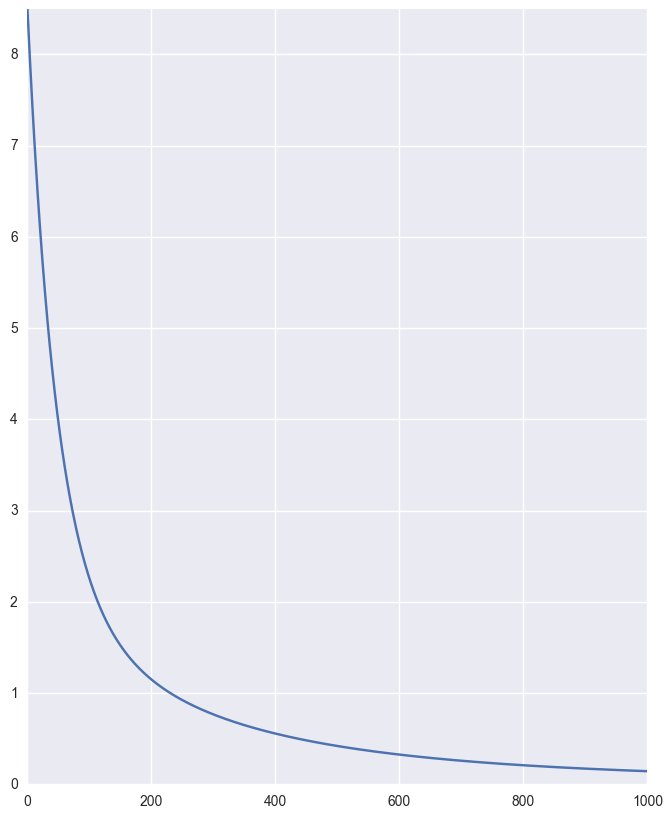

In [141]:
plt.plot(range(len(cost_history[1:])),cost_history[1:])
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

#### plot the regression line

MSE: 0.8130


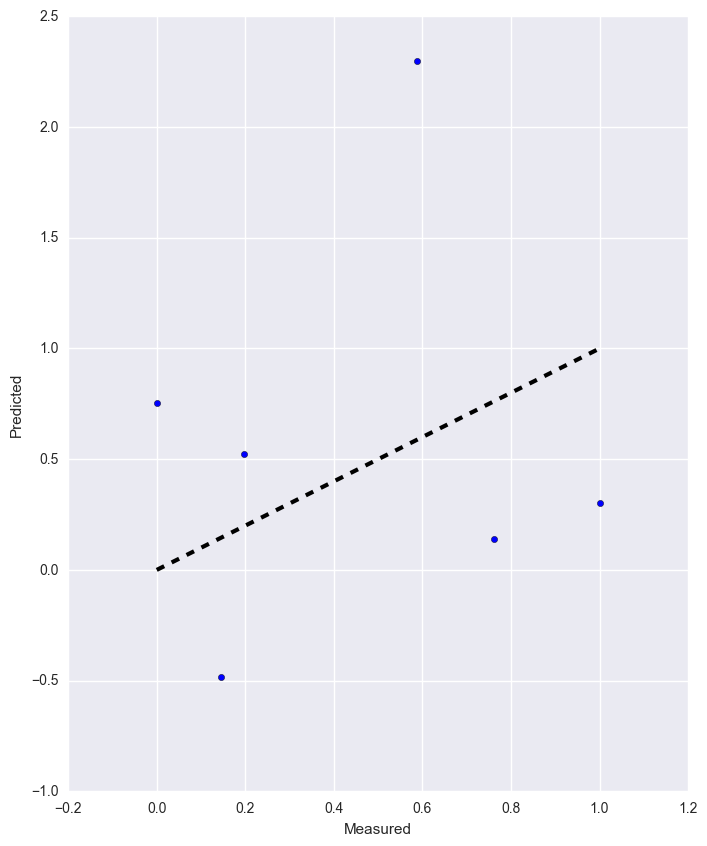

In [142]:
pred_y = sess.run(y_, feed_dict={X: valid_dataset})
mse = tf.reduce_mean(tf.square(pred_y - valid_labels))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(valid_labels, pred_y)
ax.plot([valid_labels.min(), valid_labels.max()], [valid_labels.min(), valid_labels.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [143]:
sess.close()

## Deep neural net

#### Define an acuracy measure (to be used to check validation)

In [144]:
def accuracy(predictions, labels):
    return 1 - tf.reduce_mean(tf.square(predictions - labels))

#### Define our 2 hidden layer model

In [158]:
batch_size = 10
hidden_layer1 = 1024
hidden_layer2 = 256
B = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_dataset = tf.placeholder(tf.float32, shape=(None, train_dataset.shape[1]))
    tf_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([train_dataset.shape[1], hidden_layer1], stddev=np.sqrt(2.0 / (train_dataset.shape[1]))))
    biases1 = tf.Variable(tf.zeros([hidden_layer1]))
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer1, hidden_layer2], stddev=np.sqrt(2.0 / hidden_layer1)))
    biases2 = tf.Variable(tf.zeros([hidden_layer2]))
    weights3 = tf.Variable(tf.truncated_normal([hidden_layer2, 1],  stddev=np.sqrt(2.0 / hidden_layer2)))
    biases3 = tf.Variable(tf.zeros([1]))

    # Training computation.
    hidden1 = tf.nn.sigmoid(tf.matmul(tf_dataset, weights1) + biases1)
    hidden2 = tf.nn.sigmoid(tf.matmul(hidden1, weights2) + biases2)
    #drop = tf.nn.dropout(hidden2, keep_prob) 
    out = tf.matmul(hidden2, weights3) + biases3

    loss = tf.reduce_mean(tf.nn.log_poisson_loss(out, tf_labels)
                        + B*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.sigmoid(out)
    valid_prediction = tf.nn.sigmoid(out)
    test_prediction = tf.nn.sigmoid(out)

In [159]:
num_steps = 1000
cost_history = np.empty(shape=[1],dtype=float)
loss_history = []
pred_valid = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_dataset : batch_data, tf_labels : batch_labels, keep_prob : 0.8}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        loss_history.append(l)
        if (step % 100 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: " + str(accuracy(predictions, batch_labels).eval()))
          print("Validation accuracy: " +  str(accuracy(valid_prediction.eval(
                    feed_dict = {tf_dataset : valid_dataset, keep_prob : 1}), valid_labels).eval()))
    #pred = test_prediction.eval(feed_dict = {tf_dataset : test_dataset, keep_prob : 1})
    pred_valid.append(valid_prediction.eval(feed_dict = {tf_dataset : valid_dataset, keep_prob : 1}))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 1.917562
Minibatch accuracy: 0.931212414187
Validation accuracy: 0.669047589128
Minibatch loss at step 100: 1093338752.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.668883120711
Minibatch loss at step 200: 989279040.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.668883120711
Minibatch loss at step 300: 895122816.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.668883120711
Minibatch loss at step 400: 809929856.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.668883120711
Minibatch loss at step 500: 732845888.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.668883120711
Minibatch loss at step 600: 663098880.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.668883120711
Minibatch loss at step 700: 599990464.000000
Minibatch accuracy: 0.599096272822
Validation accuracy: 0.66888312

#### Plot learning (with exponential decay)

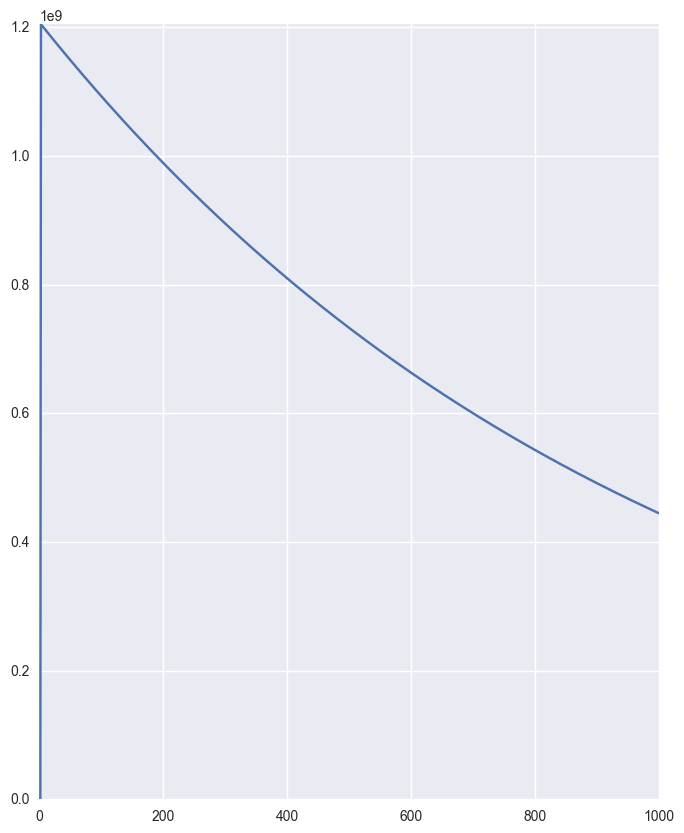

In [160]:
plt.plot(range(len(loss_history)),loss_history)
plt.axis([0,num_steps,0,np.max(loss_history)])
plt.show()

#### Plot regression line

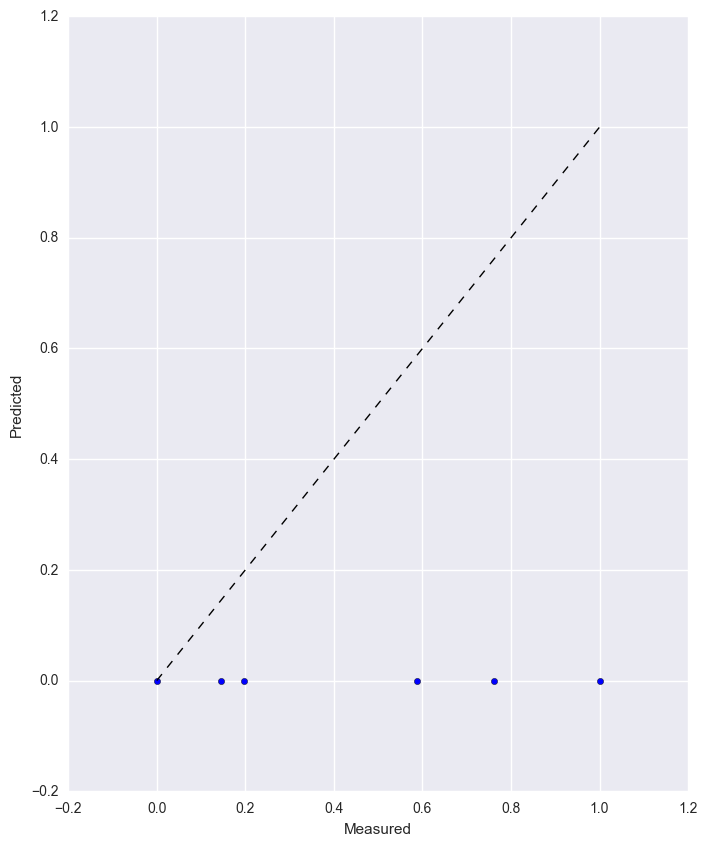

In [161]:
fig, ax = plt.subplots()
ax.scatter(valid_labels, pred_valid)
ax.plot([valid_labels.min(), valid_labels.max()], [valid_labels.min(), valid_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#### Prepare for submission

In [163]:
def un_normalize(pred, y):
    return pred * (max(y) - min(y)) + min(y)
final = un_normalize(pred.flatten(),y)

#submission = pd.DataFrame({'Id': np.array(test["Id"]), 'jump': final})
#submission.to_csv('result.csv',index=False)

/Users/orpaz/Virtual-Environments/ml/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
